In [1]:
import numpy as np
import scipy
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-11-21 13:37:23.238122: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-21 13:37:23.822613: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
test_dir = 'FER-2013/test'  
train_dir = 'FER-2013/train'   

In [3]:
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    brightness_range =[0.8,1.2],
    shear_range = 0.15,
    horizontal_flip=True
)

datagen_val = ImageDataGenerator(rescale=1./255)

In [4]:
train_generator = datagen_train.flow_from_directory(
    train_dir,
    target_size=(48, 48),    # FER images are typically 48x48
    batch_size=64,
    class_mode='categorical'
)

val_generator = datagen_val.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical'
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [5]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.regularizers import l2

# Load VGG16 pre-trained on ImageNet, without the top fully connected layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

# Freeze all layers except the last 3
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Define the emotion detection model
model = Sequential([
    base_model,  # Pre-trained VGG16 as the base
    GlobalAveragePooling2D(),  # Replace Flatten with GAP
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(7, activation='softmax')  # 7 classes for emotion detection
])

# Model summary
model.summary()

2024-11-21 13:37:27.346128: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11541 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:19:00.0, compute capability: 6.1
2024-11-21 13:37:27.346724: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 11541 MB memory:  -> device: 1, name: NVIDIA TITAN Xp, pci bus id: 0000:1a:00.0, compute capability: 6.1
2024-11-21 13:37:27.347186: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 11541 MB memory:  -> device: 2, name: NVIDIA TITAN Xp, pci bus id: 0000:67:00.0, compute capability: 6.1
2024-11-21 13:37:27.347633: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 11533 MB memory:  -> device: 3, name: NVIDIA TITAN Xp, pci bus id: 0000:68:00.0, comp

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 1

In [6]:
# Custom CNN
# model = Sequential([
#     Conv2D(256, (3, 3), activation='relu', input_shape=(48, 48, 1)),
#     BatchNormalization(),
#     MaxPooling2D(2, 2),
#     Dropout(0.3),

#     Conv2D(128, (3, 3), activation='relu'),
#     BatchNormalization(),
#     MaxPooling2D(2, 2),
#     Dropout(0.3),

#     Conv2D(64, (3, 3), activation='relu'),
#     BatchNormalization(),
#     MaxPooling2D(2, 2),
#     Dropout(0.3),

#     Flatten(),
#     Dense(256, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.5),
#     Dense(128, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.5),
#     Dense(7, activation='softmax')  # Adjust if there are more/less classes
# ])

In [7]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 1

In [9]:
history = model.fit(train_generator, validation_data=val_generator, epochs=30, verbose=1)

Epoch 1/30


2024-11-21 13:37:31.630398: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-11-21 13:37:32.126512: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f24995feb60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-21 13:37:32.126536: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA TITAN Xp, Compute Capability 6.1
2024-11-21 13:37:32.126541: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA TITAN Xp, Compute Capability 6.1
2024-11-21 13:37:32.126545: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): NVIDIA TITAN Xp, Compute Capability 6.1
2024-11-21 13:37:32.126548: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (3): NVIDIA TITAN Xp, Compute Capability 6.1
2024-11-21 13:37:32.129763: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabl

449/449 [==============================] - 38s 80ms/step - loss: 2.3676 - accuracy: 0.3138 - val_loss: 10.2381 - val_accuracy: 0.1737
Epoch 2/30
449/449 [==============================] - 36s 80ms/step - loss: 1.7221 - accuracy: 0.3777 - val_loss: 1.5980 - val_accuracy: 0.4333
Epoch 3/30
449/449 [==============================] - 35s 79ms/step - loss: 1.6144 - accuracy: 0.4064 - val_loss: 1.4507 - val_accuracy: 0.4664
Epoch 4/30
449/449 [==============================] - 35s 78ms/step - loss: 1.5744 - accuracy: 0.4140 - val_loss: 1.8169 - val_accuracy: 0.4115
Epoch 5/30
449/449 [==============================] - 35s 79ms/step - loss: 1.5347 - accuracy: 0.4275 - val_loss: 1.4003 - val_accuracy: 0.4843
Epoch 6/30
449/449 [==============================] - 37s 82ms/step - loss: 1.5066 - accuracy: 0.4347 - val_loss: 1.4178 - val_accuracy: 0.4685
Epoch 7/30
449/449 [==============================] - 36s 80ms/step - loss: 1.4899 - accuracy: 0.4414 - val_loss: 1.3451 - val_accuracy: 0.4968
Ep

In [10]:
model.save("v1-tl-small.h5")

/home/deeptimaan/.conda/envs/venv-p39-tf2/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


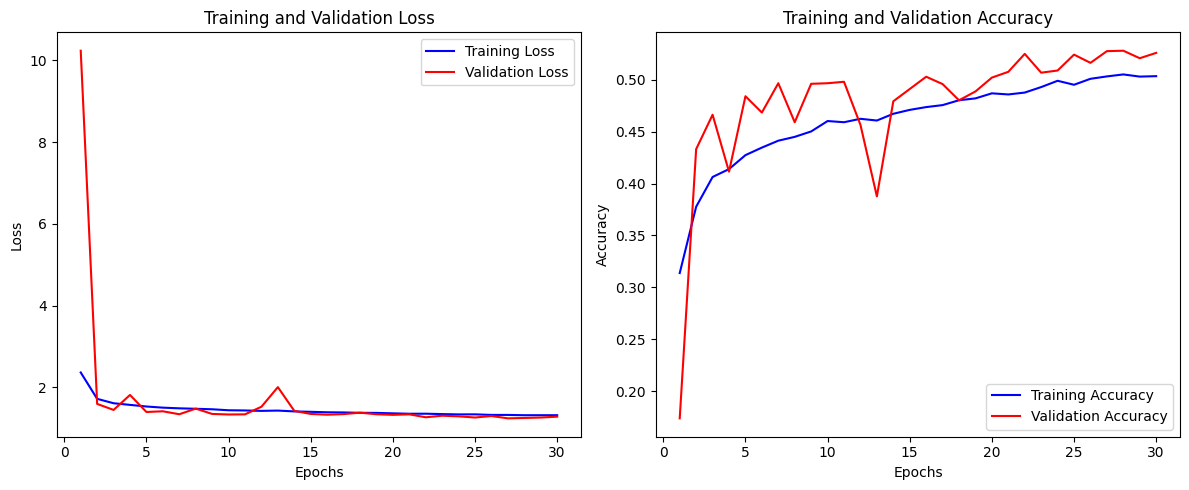

In [11]:
import matplotlib.pyplot as plt

# Extract data from history
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

# Get the number of epochs
epochs = range(1, len(loss) + 1)

# Plot loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()
